# Imports

In [31]:
from time import time
import datetime
import pandas as pd 
import numpy as np
import tensorflow as tf
import keras
from tqdm import tqdm_notebook as tqdm
#!pip install -q git+https://github.com/oanda/oandapy.git
import oandapy as opy
from datetime import datetime as dt

#!pip install statsmodels
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np
from tpot import TPOTClassifier, TPOTRegressor
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import math
from sklearn.metrics import roc_curve
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import keras.layers as kl
from keras.callbacks import TensorBoard, EarlyStopping
%matplotlib notebook

# Data

In [69]:
oanda = opy.API(environment='live')

In [ ]:
# Input for downloading data using Oanda API
d1 = '2008-01-01'
d2 = str(dt.now())[:10]
instrument = 'USD_JPY'

In [5]:
# Download data in chucks
dates = pd.date_range(start=d1, end=d2, freq='D')
df = pd.DataFrame()

print('Se van a descargar {} días'.format(len(dates)))
print('Descargando:')
for i in range(0, len(dates) -1):
    d1 = str(dates[i]).replace(' ', 'T')
    d2 = str(dates[i+1]).replace(' ', 'T')
     
    try:
        data = oanda.get_history(instrument=instrument, start=d1, end=d2, granularity='M5')
        df = df.append(pd.DataFrame(data['candles']))
        pbar.update(1)
    except:
        pass
pbar.close()
date = pd.DatetimeIndex(df['time'], tz='UTC')
df['date'] = date

Se van a descargar 3944 días
Descargando:
0
1
2
3
5
6
7
8
9
10
12
13
14
15
16
17
19
20
21
22
23
24
26
27
28
29
30
31
33
34
35
36
37
38
40
41
42
43
44
45
47
48
49
50
51
52
54
55
56
57
58
59
61
62
63
64
65
66
68
69
70
71
72
73
75
76
77
78
79
80
82
83
84
85
86
87
89
90
91
92
93
94
96
97
98
99
100
101
103
104
105
106
107
108
110
111
112
113
114
115
117
118
119
120
121
122
124
125
126
127
128
129
131
132
133
134
135
136
138
139
140
141
142
143
145
146
147
148
149
150
152
153
154
155
156
157
158
159
160
161
162
163
164
166
167
168
169
170
171
173
174
175
176
177
178
180
181
182
183
184
185
187
188
189
190
191
192
194
195
196
197
198
199
200
201
202
203
204
205
206
208
209
210
211
212
213
215
216
217
218
219
220
222
223
224
225
226
227
229
230
231
232
233
234
236
237
238
239
240
241
243
244
245
246
247
248
250
251
252
253
254
255
257
258
259
260
261
262
264
265
266
267
268
269
271
272
273
274
275
276
278
279
280
281
282
283
285
286
287
288
289
290
292
293
294
295
296
297
299
300
301
302
303
3

2061
2063
2064
2065
2066
2067
2068
2070
2071
2072
2073
2074
2075
2077
2078
2079
2080
2081
2082
2084
2085
2086
2087
2088
2089
2091
2092
2093
2094
2095
2096
2098
2099
2100
2101
2102
2103
2105
2106
2107
2108
2109
2110
2112
2113
2114
2115
2116
2117
2119
2120
2121
2122
2123
2124
2126
2127
2128
2129
2130
2131
2133
2134
2135
2136
2137
2138
2140
2141
2142
2143
2144
2145
2147
2148
2149
2150
2151
2152
2154
2155
2156
2157
2158
2159
2161
2162
2163
2164
2165
2166
2168
2169
2170
2171
2172
2173
2175
2176
2177
2178
2179
2180
2182
2183
2184
2185
2186
2187
2189
2190
2191
2192
2193
2194
2196
2197
2198
2199
2200
2201
2203
2204
2205
2206
2207
2208
2210
2211
2212
2213
2214
2215
2217
2218
2219
2220
2221
2222
2224
2225
2226
2227
2228
2229
2231
2232
2233
2234
2235
2236
2238
2239
2240
2241
2242
2243
2245
2246
2247
2248
2249
2250
2252
2253
2254
2255
2256
2257
2259
2260
2261
2262
2263
2264
2266
2267
2268
2269
2270
2271
2273
2274
2275
2276
2277
2278
2280
2281
2282
2283
2284
2285
2287
2288
2289
2290
2291
2292
2294


In [8]:
df.to_csv('USD_JPY_M5.csv')

In [9]:
DF = df.copy()

In [3]:
DF = pd.read_csv('USD_JPY_M5.csv', index_col=0)

In [4]:
df = DF.copy()

In [5]:
df

,closeAsk,closeBid,complete,highAsk,highBid,lowAsk,lowBid,openAsk,openBid,time,volume,date
0,111.786,111.586,True,111.786,111.586,111.786,111.586,111.786,111.586,2008-01-01T18:00:00.000000Z,1,2008-01-01 18:00:00+00:00
1,111.740,111.540,True,111.740,111.540,111.740,111.540,111.740,111.540,2008-01-01T18:05:00.000000Z,1,2008-01-01 18:05:00+00:00
2,111.723,111.473,True,111.765,111.515,111.723,111.473,111.765,111.515,2008-01-01T18:10:00.000000Z,3,2008-01-01 18:10:00+00:00
3,111.539,111.439,True,111.604,111.439,111.524,111.344,111.599,111.349,2008-01-01T18:35:00.000000Z,15,2008-01-01 18:35:00+00:00
4,111.555,111.455,True,111.559,111.459,111.520,111.420,111.539,111.439,2008-01-01T18:40:00.000000Z,20,2008-01-01 18:40:00+00:00
5,111.540,111.440,True,111.580,111.480,111.520,111.420,111.520,111.420,2008-01-01T18:45:00.000000Z,9,2008-01-01 18:45:00+00:00
6,111.595,111.495,True,111.595,111.495,111.540,111.440,111.540,111.440,2008-01-01T18:50:00.000000Z,23,2008-01-01 18:50:00+00:00
7,111.595,111.495,True,111.640,111.540,111.595,111.495,111.595,111.495,2008-01-01T18:55:00.000000Z,17,2008-01-01 18:55:00+00:00
8,111.595,111.495,True,111.640,111.540,111.575,111.475,111.595,111.495,2008-01-01T19:00:00.000000Z,27,2008-01-01 19:00:00+00:00
9,111.610,111.510,True,111.640,111.540,111.570,111.470,111.609,111.509,2008-01-01T19:05:00.000000Z,39,2008-01-01 19:05:00+00:00


In [6]:
df.head()

,closeAsk,closeBid,complete,highAsk,highBid,lowAsk,lowBid,openAsk,openBid,time,volume,date
0,111.786,111.586,True,111.786,111.586,111.786,111.586,111.786,111.586,2008-01-01T18:00:00.000000Z,1,2008-01-01 18:00:00+00:00
1,111.740,111.540,True,111.740,111.540,111.740,111.540,111.740,111.540,2008-01-01T18:05:00.000000Z,1,2008-01-01 18:05:00+00:00
2,111.723,111.473,True,111.765,111.515,111.723,111.473,111.765,111.515,2008-01-01T18:10:00.000000Z,3,2008-01-01 18:10:00+00:00
3,111.539,111.439,True,111.604,111.439,111.524,111.344,111.599,111.349,2008-01-01T18:35:00.000000Z,15,2008-01-01 18:35:00+00:00
4,111.555,111.455,True,111.559,111.459,111.520,111.420,111.539,111.439,2008-01-01T18:40:00.000000Z,20,2008-01-01 18:40:00+00:00


In [7]:
df = df.drop(['complete', 'time'], axis=1)

In [9]:
for i in [j for j in df.columns if j not in ['date', 'volume']]:
    df['diff ' + i] = df[i] - df[i].shift(1)

In [10]:
drp = ['closeAsk',
       'closeBid',
       'highAsk',
       'highBid',
       'lowAsk',
       'lowBid',
       'openAsk',
       'openBid']
df = df.drop(drp, axis=1)

In [11]:
min_window = 5
step = int(60/min_window)

open_bid = ['diff openBid' + str(min_window*(i+1)) for i in range(step)]
open_ask = ['diff openAsk' + str(min_window*(i+1)) for i in range(step)]
close_bid = ['diff closeBid' + str(min_window*(i+1)) for i in range(step)]
close_ask = ['diff closeAsk' + str(min_window*(i+1)) for i in range(step)]
low_bid = ['diff lowBid' + str(min_window*(i+1)) for i in range(step)]
low_ask = ['diff lowAsk' + str(min_window*(i+1)) for i in range(step)]
high_bid = ['diff highBid' + str(min_window*(i+1)) for i in range(step)]
high_ask = ['diff highAsk' + str(min_window*(i+1)) for i in range(step)]
volume = ['volume' + str(min_window*(i+1)) for i in range(step)]

In [12]:
shifts = list(range(1,step+1))

In [13]:
for v, ob, oa, cb, ca, lb, la, hb, ha, s in zip(volume,
                                             open_bid, 
                                             open_ask, 
                                             close_bid, 
                                             close_ask, 
                                             low_bid, 
                                             low_ask, 
                                             high_bid, 
                                             high_ask, 
                                             shifts):
    df[v] = df['volume'].shift(s)
    df[ob] = df['diff openBid'].shift(s)
    df[oa] = df['diff openAsk'].shift(s)
    df[cb] = df['diff closeBid'].shift(s)
    df[ca] = df['diff closeAsk'].shift(s)
    df[lb] = df['diff lowBid'].shift(s)
    df[la] = df['diff lowAsk'].shift(s)
    df[hb] = df['diff highBid'].shift(s)
    df[ha] = df['diff highAsk'].shift(s)

In [14]:
df = df[13:]

In [15]:
df['date'] = df['date'].astype(str)

In [16]:
df['d2'] = df['date'].str[14:]

In [17]:
df = df[df['d2'] == '00:00+00:00']

In [18]:
df['H'] = df.drop(['date', 'd2','volume', 'volume5', 'volume10', 'volume15', 'volume20', 'volume25', 'volume30', 'volume35', 'volume40', 'volume45', 'volume50', 'volume55', 'volume60'], 1).max(axis=1)
df['L'] = df.drop(['date', 'd2','volume', 'volume5', 'volume10', 'volume15', 'volume20', 'volume25', 'volume30', 'volume35', 'volume40', 'volume45', 'volume50', 'volume55', 'volume60'], 1).min(axis=1)
df['vol'] = df[volume].sum(axis=1)

In [19]:
drop = ['date', 'd2']
df = df.drop(drop, axis=1)

In [21]:
df.head()

,volume,diff closeAsk,diff closeBid,diff highAsk,diff highBid,diff lowAsk,diff lowBid,diff openAsk,diff openBid,volume5,diff openBid5,diff openAsk5,diff closeBid5,diff closeAsk5,diff lowBid5,diff lowAsk5,diff highBid5,diff highAsk5,volume10,diff openBid10,diff openAsk10,diff closeBid10,diff closeAsk10,diff lowBid10,diff lowAsk10,diff highBid10,diff highAsk10,volume15,diff openBid15,diff openAsk15,diff closeBid15,diff closeAsk15,diff lowBid15,diff lowAsk15,diff highBid15,diff highAsk15,volume20,diff openBid20,diff openAsk20,diff closeBid20,diff closeAsk20,diff lowBid20,diff lowAsk20,diff highBid20,diff highAsk20,volume25,diff openBid25,diff openAsk25,diff closeBid25,diff closeAsk25,diff lowBid25,diff lowAsk25,diff highBid25,diff highAsk25,volume30,diff openBid30,diff openAsk30,diff closeBid30,diff closeAsk30,diff lowBid30,diff lowAsk30,diff highBid30,diff highAsk30,volume35,diff openBid35,diff openAsk35,diff closeBid35,diff closeAsk35,diff lowBid35,diff lowAsk35,diff highBid35,diff highAsk35,volume40,diff openBid40,diff openAsk40,diff closeBid40,diff closeAsk40,diff lowBid40,diff lowAsk40,diff highBid40,diff highAsk40,volume45,diff openBid45,diff openAsk45,diff closeBid45,diff closeAsk45,diff lowBid45,diff lowAsk45,diff highBid45,diff highAsk45,volume50,diff openBid50,diff openAsk50,diff closeBid50,diff closeAsk50,diff lowBid50,diff lowAsk50,diff highBid50,diff highAsk50,volume55,diff openBid55,diff openAsk55,diff closeBid55,diff closeAsk55,diff lowBid55,diff lowAsk55,diff highBid55,diff highAsk55,volume60,diff openBid60,diff openAsk60,diff closeBid60,diff closeAsk60,diff lowBid60,diff lowAsk60,diff highBid60,diff highAsk60,H,L,vol
20,19,-0.015,-0.015,-0.009,-0.009,0.005,0.005,-0.005,-0.005,13.0,-0.005,-0.005,-0.005,-0.005,-0.025,-0.025,0.009,0.009,1.0,0.025,0.025,0.000,0.000,0.025,0.025,-0.003,-0.003,10.0,-0.025,-0.025,0.025,0.025,0.000,0.000,-0.006,-0.006,9.0,0.000,0.000,-0.025,-0.025,-0.025,-0.025,0.009,0.009,6.0,-0.005,-0.005,0.000,0.000,0.000,0.000,-0.005,-0.005,11.0,0.005,0.005,-0.005,-0.005,0.020,0.020,-0.020,-0.020,18.0,0.000,0.000,0.030,0.030,0.015,0.015,0.002,0.002,28.0,0.001,0.001,-0.025,-0.025,0.000,0.000,0.006,0.006,22.0,0.019,0.019,0.020,0.020,0.015,0.015,0.022,0.022,16.0,0.011,0.011,0.010,0.010,0.020,0.020,-0.005,-0.005,39.0,0.014,0.014,0.015,0.015,-0.005,-0.005,0.000,0.000,27.0,0.000,0.000,0.000,0.000,-0.020,-0.020,0.000,0.000,0.030,-0.025,200.0
32,1,0.000,0.000,0.000,0.000,0.076,0.076,0.041,0.041,20.0,0.005,0.005,0.041,0.041,-0.030,-0.030,0.041,0.041,9.0,0.000,0.000,0.005,0.005,0.000,0.000,0.005,0.005,6.0,-0.005,-0.005,0.000,0.000,0.022,0.022,-0.005,-0.005,23.0,0.010,0.010,-0.005,-0.005,-0.017,-0.017,0.000,0.000,7.0,0.015,0.015,0.010,0.010,0.015,0.015,0.010,0.010,17.0,0.000,0.000,0.007,0.007,0.025,0.025,0.007,0.007,8.0,0.000,0.000,0.008,0.008,-0.025,-0.025,-0.004,-0.004,7.0,0.000,0.000,-0.012,-0.012,0.000,0.000,0.000,0.000,7.0,-0.025,-0.025,0.012,0.012,0.005,0.005,-0.013,-0.013,31.0,0.015,0.015,-0.025,-0.025,0.000,0.000,0.000,0.000,15.0,-0.010,-0.010,0.015,0.015,-0.015,-0.015,-0.005,-0.005,19.0,-0.005,-0.005,-0.015,-0.015,0.005,0.005,-0.009,-0.009,0.076,-0.030,169.0
44,9,0.005,0.005,-0.030,-0.030,0.000,0.000,0.000,0.000,22.0,-0.030,-0.030,-0.025,-0.025,-0.030,-0.030,0.010,0.010,6.0,0.010,0.010,0.000,0.000,0.010,0.010,0.000,0.000,7.0,-0.010,-0.010,0.005,0.005,-0.005,-0.005,0.000,0.000,8.0,0.025,0.025,-0.005,-0.005,0.025,0.025,0.000,0.000,11.0,0.020,0.020,0.025,0.025,0.045,0.045,0.025,0.025,10.0,-0.005,-0.005,0.030,0.030,-0.020,-0.020,0.005,0.005,8.0,0.030,0.030,-0.030,-0.030,0.015,0.015,-0.005,-0.005,13.0,-0.040,-0.040,0.020,0.020,-0.015,-0.015,0.005,0.005,10.0,0.020,0.020,-0.005,-0.005,0.085,0.085,-0.036,-0.036,43.0,0.002,0.002,0.017,0.017,-0.083,-0.083,0.057,0.057,6.0,0.007,0.007,0.002,0.002,0.002,0.002,0.008,0.008,1.0,0.041,0.041,0.000,0.000,0.076,0.076,0.000,0.000,0.085,-0.083,145.0
56,39,0.051,0.051,-0.032,-0.032,0.010,0.010,-0.061,-0.061,61.0,0.054,0.054,-0.058,-0.058,-0.013,-0.013,-0.147,-0.147,114.0,0.06

In [27]:
def train_test(Data, response, time_series=False):
    """
    Regresa train y test sets con el 75% de los datos
    para entrenar y el 25% para probar el modelo
    
    Args:
        Data (DataFrame): Datos listos para el modelo
        response (str): Variable respuesta
        time_series (boolean): Si es serie de tiempo o no
    Returns:
        X_train (Array): conjunto de datos de entrenamiento (indep)
        X_test (Array): conjunto de datos de prueba (indep)
        y_train (Array): conjunto de datos de entrenamiento (dep)
        y_test (Array): conjunto de datos de prueba (dep)
        
    """
    
    Data1 = Data.copy()
    X = Data1.drop(response, 1)
    y = Data1[response]
    print('X Variables: ')
    print(X.columns)
    print('\nResponse:')
    print(response)
    
    if time_series:
        tscv = TimeSeriesSplit(n_splits=2)
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.values[train_index], X.values[test_index]
            y_train, y_test = y.values[train_index], y.values[test_index]
    
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0)
        X_train = X_train.values
        X_test = X_test.values
        y_train = y_train.values
        y_test = y_test.values
    
    return X_train, X_test, y_train, y_test

def tpotclass(X_train, y_train):
    """
    Usando TPOT (Tree-Based Pipeline Optimization Tool), librería de AutoML,
    genera el "mejor" modelo de clasificación automáticamente
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        tpotmod (modelo): Modelo de clasificación generado con TPOT
    """
    pipeline_optimizer = TPOTClassifier(generations=5,
                                        population_size=50,
                                        cv=5,
                                        random_state=42,
                                        verbosity=2,
                                        n_jobs=4)
    tpotmod = pipeline_optimizer.fit(X_train, y_train)

    return tpotmod

def tpotreg(X_train, y_train):
    """
    Usando TPOT (Tree-Based Pipeline Optimization Tool), librería de AutoML,
    genera el "mejor" modelo de regresión automáticamente
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        tpotmod (modelo): Modelo de regresión generado con TPOT
    """

    pipeline_optimizer = TPOTRegressor(generations=5,
                                       population_size=50,
                                       cv=5,
                                       random_state=42,
                                       verbosity=2,
                                       n_jobs=4)
    tpotmod = pipeline_optimizer.fit(X_train, y_train)

    return tpotmod

def logreg(X_train, y_train):
    """
    Calcula modelo de Regresión Logística
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        logreg (modelo): Regresión Logística
    """
    try:
        # Si la matriz es singular va a dar error
        log = sm.Logit(y_train, X_train)
        logreg_model = log.fit()
    except Exception as e:
        # Intentamos con la matriz hessiana
        print(e)
        log = sm.Logit(y_train, X_train)
        logreg_model = log.fit(method='bfgs')

    return logreg_model

def linreg(X_train, y_train):
    """
    Calcula modelo de Regresión Lineal
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        linreg_model (modelo): Regresión Lineal
    """
    linreg = sm.OLS(y_train, X_train)
    linreg_model = linreg.fit()

    return linreg_model

def simple_model(X_train, y_train, tpot=False):
    """
    Obtiene variable objetivo, decide si es de clasificación o regresión
    y regresa un modelo simple
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
        tpot (boolean): si queremos generar modelo con tpot
    Returns:
        model (modelo): Regresión Logística o Lineal dependiendo de la variable
                         objetivo
        tpotmod (modelo): Modelo de Regresión o Clasificación generado con TPOT
    """
    tpotm = None
    # Revisamos si es modelo de clasificación binaria
    if len(set(np.unique(y_train))) == 2:
        model = logreg(X_train, y_train)
        if tpot:
            toptm = tpotclass(X_train, y_train)
    elif len(set(np.unique(y_train))) > 2 and len(set(np.unique(y_train))) < 10:
        multilog = sm.MNLogit(y_train, X_train)
        model = multilog.fit()
        if tpot:
            tpotm = tpotclass(X_train, y_train)
    else:
        model = linreg(X_train, y_train)
        if tpot:
            tpotm = tpotreg(X_train, y_train)

    return model, tpotm


  
def rnn_reg(X_train, y_train, bs=1024, epcs=100):
  
    model = Sequential()

    model.add(LSTM(1000, activation='tanh', return_sequences=True, input_shape=(1, X_train.shape[1]), recurrent_dropout=0.5))
    model.add(LSTM(100, activation='tanh', return_sequences=True, recurrent_activation = 'hard_sigmoid', recurrent_dropout=0.4))          
    model.add(LSTM(10, activation='tanh', recurrent_activation = 'hard_sigmoid', recurrent_dropout=0.2))
    model.add(Dense(activation="linear", units=1))

    model.compile(loss ="mean_squared_error" , optimizer = "adam", metrics = ["mean_squared_error", "accuracy"])
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    
    tensorboard = TensorBoard(log_dir="logs/{}(batches {})".format(datetime.datetime.now(),bs), 
                              histogram_freq=0, 
                              batch_size=bs, 
                              write_graph=True, 
                              write_grads=False, 
                              write_images=False, 
                              update_freq='epoch')
    
    early_stopping = EarlyStopping(monitor='val_loss',
                                   min_delta=0,
                                   patience=5,
                                   verbose=1,
                                   mode='auto',
                                   restore_best_weights= True)
    
    model.fit(X_train, y_train, verbose=1, batch_size=bs, epochs=epcs, validation_split=0.25, callbacks=[tensorboard, early_stopping])
   
    return model

def rnn_class(X_train, y_train, bs=1024, epcs=5):
    
    model = Sequential()
    
    model.add(LSTM(1000, activation='tanh', return_sequences=True, input_shape=(1, X_train.shape[1]), recurrent_dropout=0.5))
    model.add(LSTM(100, activation='tanh', return_sequences=True, recurrent_activation = 'hard_sigmoid', recurrent_dropout=0.4))          
    model.add(LSTM(10, activation='tanh', recurrent_activation = 'hard_sigmoid', recurrent_dropout=0.2))
    
    model.add(Dense(activation="linear", units=1))

    model.compile(loss ="mean_squared_error" , optimizer = "adam", metrics = ["mean_squared_error", "accuracy"])
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    
    tensorboard = TensorBoard(log_dir="logs/{}(batches {})".format(datetime.datetime.now(),bs), histogram_freq=0, batch_size=bs, write_graph=True, write_grads=False, write_images=False, update_freq='epoch')
    model.fit(X_train, y_train, shuffle = False, verbose=1, batch_size=bs, epochs=epcs, validation_split=0.05, callbacks=[tensorboard])
   
    return model

def model_precision(y_test, predictions, lim):
    """
    Args:
        y_test (array): Instancias de la variable dependiente
        predictions (array): Predicciones
        lim (float): Entre 0 y 1 que marca el límite de clasificación (arriba de lim se considera cierre)
    
    Returns:
        Accuracy (float): (tp+tn)/(tp+tn+fp+fn)
        Precision (float): tp/(tp+fp)
        Recall (float): tp/(tp+fn)
        F1_score (float): 2/(1/Precision+1/Recall) Media armónica entre Precision y Recall
        MCC (float): Matthiews Correlation Coefficient (tp*tn-fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    
    """
          
    y_test.shape = [y_test.shape[0],1]
    predictions.shape = [predictions.shape[0],1]
    
    test = np.concatenate((y_test, predictions),axis=1)

    tp = ((test[:,0] == 1) & (test[:,1] >= lim)).sum()
    fp = ((test[:,0] == 0) & (test[:,1] >= lim)).sum()
    tn = ((test[:,0] == 0) & (test[:,1] < lim)).sum()
    fn = ((test[:,0] == 1) & (test[:,1] < lim)).sum()
    
    Accuracy = (tp+tn)/(tp+tn+fp+fn)
    Precision = tp/(tp+fp)
    Recall = tp/(tp+fn)
    F1_score = 2/(1/Precision+1/Recall)
    MCC = (tp*tn-fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    

    res = pd.DataFrame(0, index=['Accuracy', 'Precision',
                                     'Recall', 'F1 Score',
                                     'MCC'], columns=['Score'])

    res.loc['Accuracy'] = 100*Accuracy
    res.loc['Precision'] = 100*Precision
    res.loc['Recall'] = 100*Recall
    res.loc['F1 Score'] = 100*F1_score
    res.loc['MCC'] = 100*MCC
    display(res)
    
    return Accuracy, Precision, Recall, F1_score, MCC

def bucket_scores(y_test, predictions):
    """
    Precision por cubeta de 10 en 10
    
    Args:
        y_test (array): Instancias de la variable dependiente
        predictions (array): Predicciones
    
    Returns:
        res (DataFrame): Positive rate por scores de 1 a 100 en cubetas de 10
    
    """
    scoresindex = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100']
    scorescolumns = ['Total','Positives']
    res = pd.DataFrame(0, index=scoresindex, columns=scorescolumns)
    
    y_test.shape = [y_test.shape[0],1]
    predictions.shape = [predictions.shape[0],1]
    
    test = np.concatenate((y_test,predictions),axis=1)
    
    low = 0
    up = 0.1
    for i in scoresindex:
        res.loc[i]['Total'] = ((test[:,1] >= low) & (test[:,1] < up)).sum()
        res.loc[i]['Positives'] = ((test[:,1] >= low) & (test[:,1] < up) & (test[:,0] == 1)).sum()
        low += 0.1
        up += 0.1
    res['Positive Rate'] = res['Positives']/res['Total']*100  
    
    return res

# Price

## Future Close (price)

In [28]:
df_fc.head()

,volume,diff closeAsk,diff closeBid,diff highAsk,diff highBid,diff lowAsk,diff lowBid,diff openAsk,diff openBid,volume5,diff openBid5,diff openAsk5,diff closeBid5,diff closeAsk5,diff lowBid5,diff lowAsk5,diff highBid5,diff highAsk5,volume10,diff openBid10,diff openAsk10,diff closeBid10,diff closeAsk10,diff lowBid10,diff lowAsk10,diff highBid10,diff highAsk10,volume15,diff openBid15,diff openAsk15,diff closeBid15,diff closeAsk15,diff lowBid15,diff lowAsk15,diff highBid15,diff highAsk15,volume20,diff openBid20,diff openAsk20,diff closeBid20,diff closeAsk20,diff lowBid20,diff lowAsk20,diff highBid20,diff highAsk20,volume25,diff openBid25,diff openAsk25,diff closeBid25,diff closeAsk25,diff lowBid25,diff lowAsk25,diff highBid25,diff highAsk25,volume30,diff openBid30,diff openAsk30,diff closeBid30,diff closeAsk30,diff lowBid30,diff lowAsk30,diff highBid30,diff highAsk30,volume35,diff openBid35,diff openAsk35,diff closeBid35,diff closeAsk35,diff lowBid35,diff lowAsk35,diff highBid35,diff highAsk35,volume40,diff openBid40,diff openAsk40,diff closeBid40,diff closeAsk40,diff lowBid40,diff lowAsk40,diff highBid40,diff highAsk40,volume45,diff openBid45,diff openAsk45,diff closeBid45,diff closeAsk45,diff lowBid45,diff lowAsk45,diff highBid45,diff highAsk45,volume50,diff openBid50,diff openAsk50,diff closeBid50,diff closeAsk50,diff lowBid50,diff lowAsk50,diff highBid50,diff highAsk50,volume55,diff openBid55,diff openAsk55,diff closeBid55,diff closeAsk55,diff lowBid55,diff lowAsk55,diff highBid55,diff highAsk55,volume60,diff openBid60,diff openAsk60,diff closeBid60,diff closeAsk60,diff lowBid60,diff lowAsk60,diff highBid60,diff highAsk60,H,L,vol,Future CloseBid
20,-0.020377,-0.003756,-0.003987,-0.004790,-0.004673,0.001874,0.001991,-0.002354,-0.001787,-0.024470,-0.001939,-0.001988,-0.002724,-0.003550,-0.012196,-0.012417,0.003312,0.003083,-0.034124,0.011290,0.011319,-0.000055,-0.000115,0.008869,0.009613,-0.001931,-0.001826,-0.015942,-0.006691,-0.007012,0.011222,0.011177,0.000054,-0.000032,-0.002241,-0.002398,-0.015414,-0.000074,-0.000050,-0.006673,-0.006942,-0.003694,-0.003771,0.006324,0.006034,-0.029544,-0.002022,-0.001657,-0.000083,-0.000053,-0.001424,-0.001079,-0.001061,-0.000831,-0.025219,0.001637,0.001258,-0.002007,-0.001665,0.005680,0.005643,-0.010532,-0.010748,-0.032722,0.000055,0.000081,0.009294,0.008851,0.008646,0.008532,0.000768,0.000646,-0.022706,0.000520,0.000651,-0.011278,-0.011459,-0.000248,-0.000176,0.002529,0.002563,-0.028260,0.007684,0.007827,0.009078,0.009197,0.003820,0.004029,0.011392,0.011771,-0.028653,0.006604,0.006727,0.004045,0.004107,0.005945,0.006217,-0.002252,-0.002189,-0.022774,0.003935,0.004262,0.009070,0.009228,-0.004036,-0.003577,0.000970,0.001249,-0.019665,0.000124,-0.000398,-0.000033,0.000234,-0.003902,-0.004105,-0.001190,-0.001360,-0.016326,0.010805,-0.041454,-0.000031
32,-0.021994,0.000250,-0.000031,-0.001346,-0.001173,0.018860,0.018724,0.015545,0.015899,-0.023622,0.001847,0.001798,0.023622,0.023864,-0.014776,-0.014996,0.016746,0.016405,-0.032769,0.000074,0.000002,0.001835,0.001850,0.000041,-0.000003,0.002894,0.002558,-0.016275,-0.001357,-0.001467,0.000116,-0.000018,0.007593,0.007507,-0.001866,-0.002014,-0.014286,0.003622,0.003559,-0.001370,-0.001433,-0.002531,-0.002583,0.000189,0.000193,-0.029397,0.005278,0.006014,0.003606,0.003548,0.006998,0.007887,0.003598,0.003743,-0.024501,0.000111,-0.000252,0.002357,0.002922,0.006929,0.006901,0.002032,0.001934,-0.034605,0.000055,0.000081,0.002560,0.002187,-0.014329,-0.014669,-0.001196,-0.001290,-0.025527,0.000070,0.000200,-0.005387,-0.005460,-0.000248,-0.000176,0.000300,0.000363,-0.030593,-0.010022,-0.010325,0.005479,0.005598,0.001295,0.001372,-0.006584,-0.006777,-0.026384,0.009012,0.009130,-0.010034,-0.010320,-0.000220,-0.000193,0.000378,0.000444,-0.025897,-0.002937,-0.002539,0.009070,0.009228,-0.008705,-0.008224,-0.000637,-0.000353,-0.020384,-0.001799,-0.002344,-0.003989,-0.003772,0.001990,0.001876,-0.004689,-0.004805,0.001935,0.009657,-0.042011,0.001287
44,-0.021276,0

X Variables: 
Index(['volume', 'diff closeAsk', 'diff closeBid', 'diff highAsk',
       'diff highBid', 'diff lowAsk', 'diff lowBid', 'diff openAsk',
       'diff openBid', 'volume5',
       ...
       'diff openAsk60', 'diff closeBid60', 'diff closeAsk60', 'diff lowBid60',
       'diff lowAsk60', 'diff highBid60', 'diff highAsk60', 'H', 'L', 'vol'],
      dtype='object', length=120)

Response:
Future CloseBid


<IPython.core.display.Javascript object>


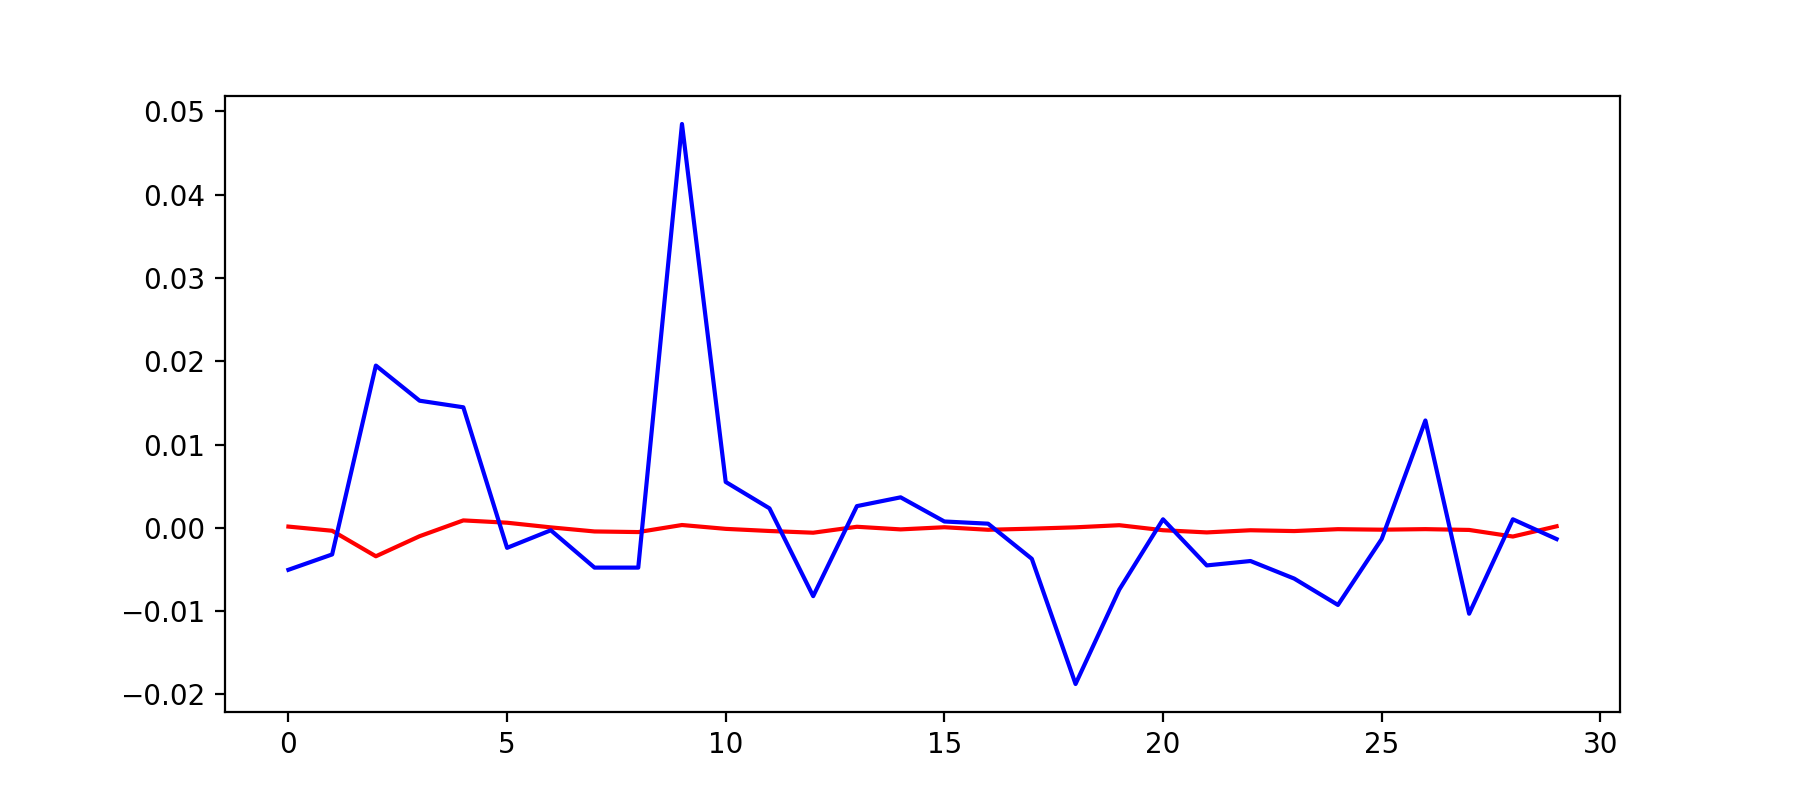

Train on 33913 samples, validate on 11305 samples
Epoch 1/100
33913/33913 [==============================] - 21s 613us/step - loss: 1.8253e-04 - mean_squared_error: 1.8253e-04 - acc: 0.0000e+00 - val_loss: 1.5099e-04 - val_mean_squared_error: 1.5099e-04 - val_acc: 0.0000e+00
Epoch 2/100
33913/33913 [==============================] - 19s 552us/step - loss: 1.8164e-04 - mean_squared_error: 1.8164e-04 - acc: 0.0000e+00 - val_loss: 1.5112e-04 - val_mean_squared_error: 1.5112e-04 - val_acc: 0.0000e+00
Epoch 3/100
33913/33913 [==============================] - 21s 626us/step - loss: 1.8134e-04 - mean_squared_error: 1.8134e-04 - acc: 0.0000e+00 - val_loss: 1.5152e-04 - val_mean_squared_error: 1.5152e-04 - val_acc: 0.0000e+00
Epoch 4/100
33913/33913 [==============================] - 18s 531us/step - loss: 1.8127e-04 - mean_squared_error: 1.8127e-04 - acc: 0.0000e+00 - val_loss: 1.5109e-04 - val_mean_squared_error: 1.5109e-04 - val_acc: 0.0000e+00
Epoch 5/100
33913/33913 [=====================

<IPython.core.display.Javascript object>


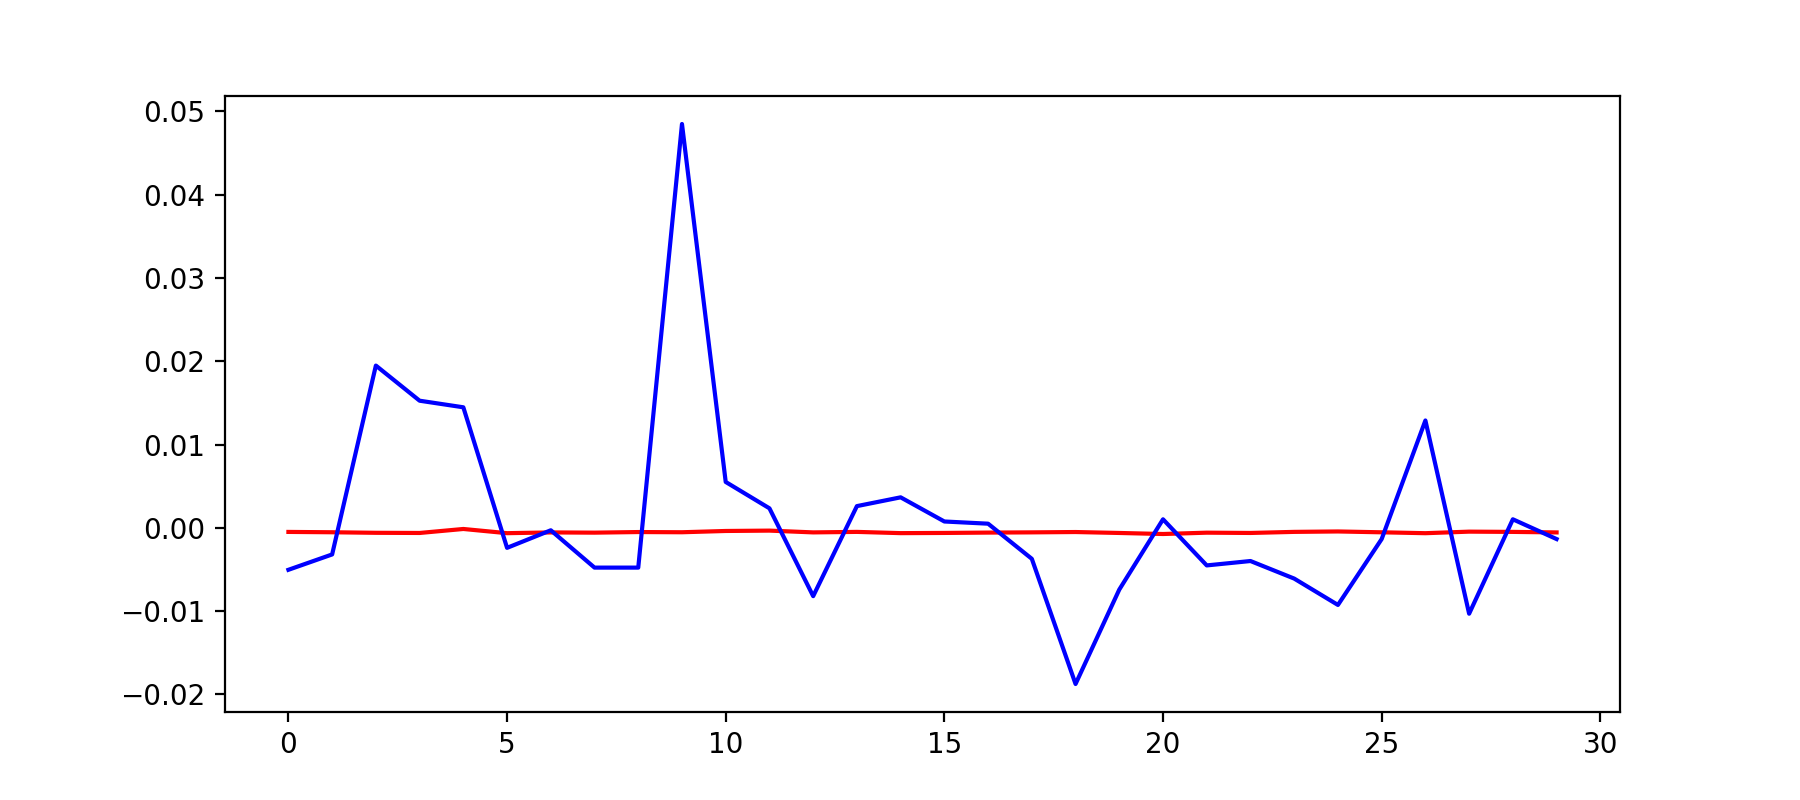

In [32]:
df_fc = df.copy()

df_fc = (df_fc - df_fc.mean()) / (df_fc.max() - df_fc.min())

response = 'Future CloseBid'

actual = 'diff closeBid'

df_fc[response] = df_fc[actual].shift(-1)

df_fc = df_fc.dropna()

X_train, X_test, y_train, y_test = train_test(df_fc, response, time_series=True)

### LINREG (price)

lr_fc = linreg(X_train, y_train)
#print(lr_fc.summary())
plt.figure(figsize=(9,4))
plt.plot(range(len(y_test[:30])),lr_fc.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

### RNN (price)

nn_fc = rnn_reg(X_train, y_train)
print(nn_fc.summary())
plt.figure(figsize=(9,4))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

plt.plot(range(len(y_test[:30])),nn_fc.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

In [ ]:
## LINREG (price)

lr_fc = linreg(X_train, y_train)
#print(lr_fc.summary())
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test[:30])),lr_fc.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

### RNN (price)

nn_fc = rnn_reg(X_train, y_train, bs=512, epcs=25)
print(nn_fc.summary())
plt.figure(figsize=(15,4))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
plt.plot(range(len(y_test[:30])),nn_fc.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

# Future High (price)

X Variables: 
Index(['volume', 'diff closeAsk', 'diff closeBid', 'diff highAsk',
       'diff highBid', 'diff lowAsk', 'diff lowBid', 'diff openAsk',
       'diff openBid', 'volume5',
       ...
       'diff openAsk60', 'diff closeBid60', 'diff closeAsk60', 'diff lowBid60',
       'diff lowAsk60', 'diff highBid60', 'diff highAsk60', 'H', 'L', 'vol'],
      dtype='object', length=120)

Response:
Future diff highBid
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     4.703
Date:                Mon, 22 Oct 2018   Prob (F-statistic):           8.63e-58
Time:                        20:19:21   Log-Likelihood:                 77589.
No. Observations:               45218   AIC:                        -1.549e+05
Df Residuals:                

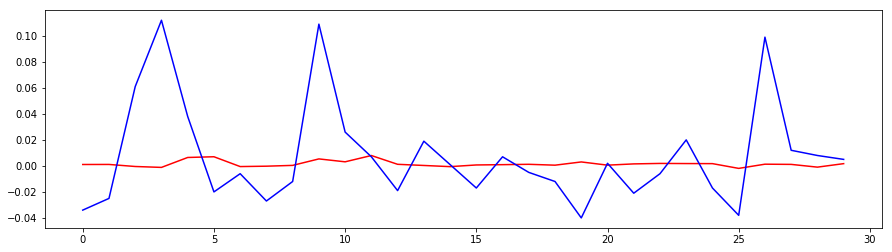

Train on 42957 samples, validate on 2261 samples
Epoch 1/5
42957/42957 [==============================] - 31s 723us/step - loss: 0.0022 - mean_squared_error: 0.0022 - acc: 0.0506 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_acc: 0.0226
Epoch 2/5
42957/42957 [==============================] - 25s 594us/step - loss: 0.0019 - mean_squared_error: 0.0019 - acc: 0.0506 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_acc: 0.0226
Epoch 3/5
42957/42957 [==============================] - 28s 657us/step - loss: 0.0019 - mean_squared_error: 0.0019 - acc: 0.0506 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_acc: 0.0226
Epoch 4/5
42957/42957 [==============================] - 25s 579us/step - loss: 0.0019 - mean_squared_error: 0.0019 - acc: 0.0506 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_acc: 0.0226
Epoch 5/5
42957/42957 [==============================] - 26s 603us/step - loss: 0.0019 - mean_squared_error: 0.0019 - acc: 0.0506 - val_loss: 0.0022 - 

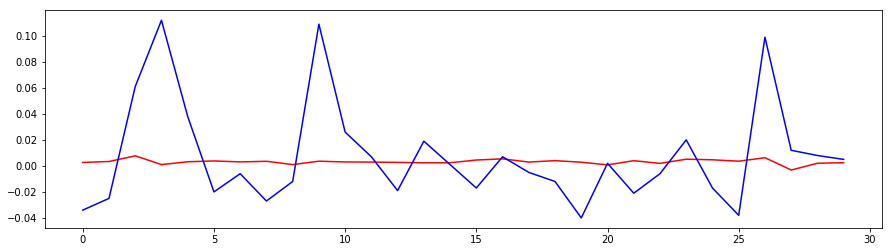

In [34]:
df_fh = df.copy()

response = 'Future diff highBid'
actual = 'diff highBid'
df_fh[response] = df_fh[actual].shift(-1)

df_fh = df_fh.dropna()

X_train, X_test, y_train, y_test = train_test(df_fh, response, time_series=True)

### LINREG (price)

lr_fh = linreg(X_train, y_train)
print(lr_fh.summary())
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test[:30])),lr_fh.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

### RNN (price)

nn_fh = rnn_reg(X_train, y_train, bs=512, epcs=5)
print(nn_fh.summary())
plt.figure(figsize=(15,4))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
plt.plot(range(len(y_test[:30])),nn_fh.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

# Future Low (price)

X Variables: 
Index(['volume', 'diff closeAsk', 'diff closeBid', 'diff highAsk',
       'diff highBid', 'diff lowAsk', 'diff lowBid', 'diff openAsk',
       'diff openBid', 'volume5',
       ...
       'diff openAsk60', 'diff closeBid60', 'diff closeAsk60', 'diff lowBid60',
       'diff lowAsk60', 'diff highBid60', 'diff highAsk60', 'H', 'L', 'vol'],
      dtype='object', length=120)

Response:
Future diff lowBid
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     4.731
Date:                Mon, 22 Oct 2018   Prob (F-statistic):           2.31e-58
Time:                        20:21:55   Log-Likelihood:                 78071.
No. Observations:               45218   AIC:                        -1.559e+05
Df Residuals:                 

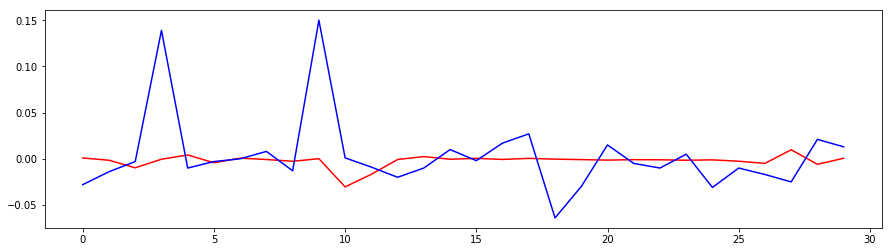

Train on 42957 samples, validate on 2261 samples
Epoch 1/5
42957/42957 [==============================] - 33s 768us/step - loss: 0.0028 - mean_squared_error: 0.0028 - acc: 0.0479 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_acc: 0.0172
Epoch 2/5
42957/42957 [==============================] - 28s 649us/step - loss: 0.0018 - mean_squared_error: 0.0018 - acc: 0.0479 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_acc: 0.0172
Epoch 3/5
18432/42957 [===========>..................] - ETA: 13s - loss: 0.0018 - mean_squared_error: 0.0018 - acc: 0.0490

KeyboardInterrupt: 

In [35]:
df_fl = df.copy()

response = 'Future diff lowBid'

actual = 'diff lowBid'

df_fl[response] = df_fl[actual].shift(-1)

df_fl = df_fl.dropna()

X_train, X_test, y_train, y_test = train_test(df_fl, response, time_series=True)

### LINREG (price)

lr_fl = linreg(X_train, y_train)
print(lr_fl.summary())
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test[:30])),lr_fl.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

### RNN (price)

nn_fl = rnn_reg(X_train, y_train, bs=512, epcs=5)
print(nn_fl.summary())
plt.figure(figsize=(15,4))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
plt.plot(range(len(y_test[:30])),nn_fl.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

# Score

## Future Close (higher)

In [ ]:
df_fc = df.copy()
actual = 'diff closeBid'
response = 'Future close higher'
lim = 0.5
df_fc[response] = 0
df_fc.loc[df_fc[actual] >= 0, response] = 1
df_fc[response] = df_fc[response].shift(-1)
df_fc = df_fc.dropna()
X_train, X_test, y_train, y_test = train_test(df_fc, response, time_series=True)

### LOGREG
print('LOGREG')
lr_fc = logreg(X_train, y_train)
predictions = lr_fc.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

plt.figure(figsize=(17,18))
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'r')
auc = np.trapz(tpr, fpr)
plt.axis([0,1,0,1])
plt.plot([0,1],[0,1], 'black')


### RNN 
print('RNN CLASS')
nn_fc = rnn_class(X_train, y_train, bs=512, epcs=20)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
predictions = nn_fc.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'b')

plt.show()

## Future High (higher)

In [ ]:
df_fh = df.copy()
actual = 'diff highBid'
response = 'Future high higher'
lim = 0.5
df_fh[response] = 0
df_fh.loc[df_fh[actual] >= 0, response] = 1
df_fh[response] = df_fh[response].shift(-1)
df_fh = df_fh.dropna()
X_train, X_test, y_train, y_test = train_test(df_fh, response, time_series=True)

### LOGREG
print('LOGREG')
lr_fh = logreg(X_train, y_train)
predictions = lr_fh.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

plt.figure(figsize=(17,18))
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'r')
auc = np.trapz(tpr, fpr)
plt.axis([0,1,0,1])
plt.plot([0,1],[0,1], 'black')

### RNN 
print('RNN CLASS')
nn_fh = rnn_class(X_train, y_train, bs=512, epcs=20)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
predictions = nn_fh.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'b')

plt.show()

## Future Low (higher)

In [ ]:
df_fl = df.copy()
actual = 'diff lowBid'
response = 'Future low higher'
lim = 0.5
df_fl[response] = 0
df_fl.loc[df_fl[actual] >= 0, response] = 1
df_fl[response] = df_fl[response].shift(-1)
df_fl = df_fl.dropna()
X_train, X_test, y_train, y_test = train_test(df_fl, response, time_series=True)

### LOGREG
print('LOGREG')
lr_fl = logreg(X_train, y_train)
predictions = lr_fl.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

plt.figure(figsize=(17,18))
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'r')
auc = np.trapz(tpr, fpr)
plt.axis([0,1,0,1])
plt.plot([0,1],[0,1], 'black')

### RNN 
print('RNN CLASS')
nn_fl = rnn_class(X_train, y_train, bs=512, epcs=20)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
predictions = nn_fl.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'b')

plt.show()

# Trading

In [144]:
response = oanda.get_history(instrument="USD_JPY", granularity='M5', since='2018-08-23T01:00:00.00000Z')

In [150]:
pd.DataFrame(response['candles'])

,closeAsk,closeBid,complete,highAsk,highBid,lowAsk,lowBid,openAsk,openBid,time,volume
0,112.362,112.349,True,112.392,112.380,112.360,112.347,112.381,112.369,2018-10-12T06:05:00.000000Z,301
1,112.371,112.359,True,112.380,112.367,112.364,112.351,112.364,112.351,2018-10-12T06:10:00.000000Z,376
2,112.374,112.361,True,112.380,112.366,112.338,112.324,112.369,112.357,2018-10-12T06:15:00.000000Z,575
3,112.392,112.379,True,112.406,112.392,112.371,112.359,112.372,112.360,2018-10-12T06:20:00.000000Z,328
4,112.436,112.424,True,112.440,112.427,112.393,112.381,112.393,112.381,2018-10-12T06:25:00.000000Z,582
5,112.447,112.435,True,112.457,112.444,112.423,112.410,112.435,112.422,2018-10-12T06:30:00.000000Z,759
6,112.475,112.463,True,112.485,112.472,112.419,112.406,112.446,112.434,2018-10-12T06:35:00.000000Z,562
7,112.490,112.478,True,112.491,112.479,112.466,112.453,112.476,112.464,2018-10-12T06:40:00.000000Z,408
8,112.482,112.470,True,112.504,112.492,112.476,112.462,112.489,112.476,2018-10-12T06:45:00.000000Z,463
9,112.472,112.459,True,112.495,112.483,112.469,112.456,112.484,112.471,2018-10-12T06:50:00.000000Z,359
